In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import matplotlib as mpl
mpl.rc('image', cmap='RdYlBu_r')

In [2]:
# bim means 'binned image'
bim_dict = np.load('bim_dict.npy',allow_pickle=True)[()]
bim     = bim_dict['data']
x_range = bim_dict['x_range']
y_range = bim_dict['y_range']
del bim_dict

# n_frames, n_x, n_y
nf, nx, ny = bim.shape
print(nf, nx, ny)

90000 76 126


In [3]:
from scipy import stats, optimize, interpolate, ndimage

In [4]:
raw_md = pd.read_csv('TES_metadata.csv', index_col=0)

In [5]:
# dump the top 1% of beam areas 
g = raw_md['area']  < np.percentile(raw_md['area'] ,q=99)
ngf = g.sum()
print(ngf) # n good frames

# AREA and metadata for good data only 
md = raw_md.loc[g]

# flattened binned images 
fbim = np.concatenate([_bim.ravel()[None,:] for _bim in bim],axis=0)

# good flattened binned images (our dataset)
gfbim = fbim[g]

gfbim_avg = gfbim.mean(axis=0)

89100


In [6]:
fbim.shape

(90000, 9576)

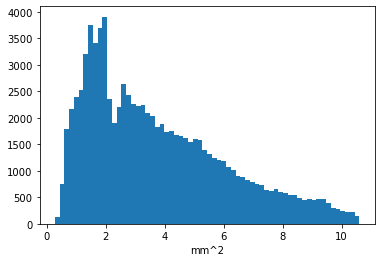

In [7]:
plt.hist(md['area'],bins=64)
plt.xlabel('mm^2')
plt.show()

In [8]:
test_index  = np.random.choice(np.arange(ngf),size=int(5e-2*ngf),replace=False)
train_index = np.arange(ngf)[~np.isin(np.arange(ngf), test_index)]
train_index.shape, test_index.shape

((84645,), (4455,))

In [9]:
nmd = md.copy() # normalized metadata, easier for the nn to fit to
val_min, val_ptp = {}, {} # save scaling, so we can recover true metadata
for col in md:
    val_min[col] = md[col].min()
    val_ptp[col] = md[col].max() - md[col].min()
    nmd[col] = (md[col]-val_min[col]) / val_ptp[col]

In [10]:
!pip install torch
import torch
import torch.nn as nn

In [11]:
x_columns = nmd.columns[[0,1,2,3]]
x_df = pd.DataFrame(nmd, columns=x_columns)
x_df.describe()

,toroidal_mirror_dsy,toroidal_mirror_ush,toroidal_mirror_dsh,toroidal_mirror_usy
count,89100.000000,89100.000000,89100.000000,89100.000000
mean,0.499138,0.496134,0.504232,0.501434
std,0.297810,0.318046,0.317699,0.297725
min,0.000000,0.000000,0.000000,0.000000
25%,0.241381,0.222261,0.222240,0.241400
50%,0.482762,0.444435,0.555520,0.517250
75%,0.758619,0.777739,0.777760,0.758600
max,1.000000,1.000000,1.000000,1.000000


In [12]:
x = torch.tensor(x_df.values, dtype=torch.float)
y = torch.tensor(gfbim - gfbim_avg, dtype=torch.float)

In [13]:
pd.isna(nmd).sum() # just to be safe!

toroidal_mirror_dsy    0
toroidal_mirror_ush    0
toroidal_mirror_dsh    0
toroidal_mirror_usy    0
area                   0
dtype: int64

In [25]:
class Net(nn.Module):
    def __init__(self, dim_in, hidden_n, dim_out):
        
        h1, h2, h3, h4 = hidden_n
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(dim_in, h1)
        self.linear2 = nn.Linear(h1, h2)
        self.linear3 = nn.Linear(h2, h3)
        self.linear4 = nn.Linear(h3, h4)
        self.linear5 = nn.Linear(h4, dim_out)
        
    def forward(self, x):
        y_pred = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(y_pred).clamp(min=0)
        y_pred = self.linear3(y_pred).clamp(min=0)
        y_pred = self.linear4(y_pred).clamp(min=0)
        y_pred = self.linear5(y_pred)
        return y_pred

In [26]:
hidden_n = [1024, 1024, 1024, 1024]

dim_in, dim_out = x.shape[1], y.shape[1]
dim_in, dim_out

(4, 9576)

In [27]:
model  = Net(dim_in, hidden_n, dim_out)
losses = []

In [32]:
path = 'torch-models/TES-im-1024x4'

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss(reduction='mean')

In [21]:
linear = lambda x, a, b: a*x+b

import time

def train(model, steps, train_batch_size, test_batch_size, save_every=1000, stats_every=10):
    
    global losses
    loss_string = ''
    gate_times  = [time.time()]
    for t in range(steps):

        train_batch_index = np.random.choice(train_index, train_batch_size, replace=False)
        y_pred = model(x[train_batch_index])
        loss = criterion(y_pred, y[train_batch_index])

        if torch.isnan(loss): break

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        test_batch_index = np.random.choice(test_index, test_batch_size, replace=False)
        y_pred = model(x[test_batch_index])
        test_loss = criterion(y_pred, y[test_batch_index])
        losses.append(test_loss.item())

        gate_times.append(time.time())

        # if (t+1) % save_every == 0: torch.save(model.state_dict(), path)

        if not (t+1) % stats_every == 0: continue

        elapsed = int(np.ptp(gate_times))
        eta     = int((steps-(t+1))/(t+1) * elapsed)
        mtpl    = np.diff(gate_times[-1024:]).mean()
        l, m, u = np.percentile(losses[-1024:],q=[2.5,50,97.5])

        if len(losses) > 1024:
            (a,b), cpars = sp.optimize.curve_fit(linear, np.arange(-512,512), losses[-1024:], p0=[0,losses[-1]])
            loss_string  = f'loss = {b:.05f} (Δ = {a:.03f} ± {2*np.sqrt(cpars[0,0]):.03f} /it)'
        print(f'{loss_string} | it = {t+1}/{steps} | {1/mtpl:.02f} it/s | [{int(eta/60)}:{eta%60:02} ==> {int(elapsed/60)}:{elapsed%60:02}]')
        clear_output(wait=True)
        
    return model
    

In [33]:
# train the model:
# train(model, steps=10000, train_batch_size=256, test_batch_size=256, save_every=1000, stats_every=10)
#
# or load the pretrained one:
model.load_state_dict(torch.load(path))

model.eval()

Net(
  (linear1): Linear(in_features=4, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=1024, bias=True)
  (linear4): Linear(in_features=1024, out_features=1024, bias=True)
  (linear5): Linear(in_features=1024, out_features=9576, bias=True)
)

[]

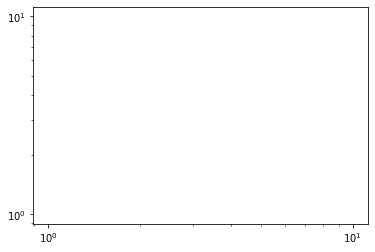

In [34]:
plt.plot(1+np.arange(len(losses)),losses)
plt.loglog()

Text(0, 0.5, 'mm')

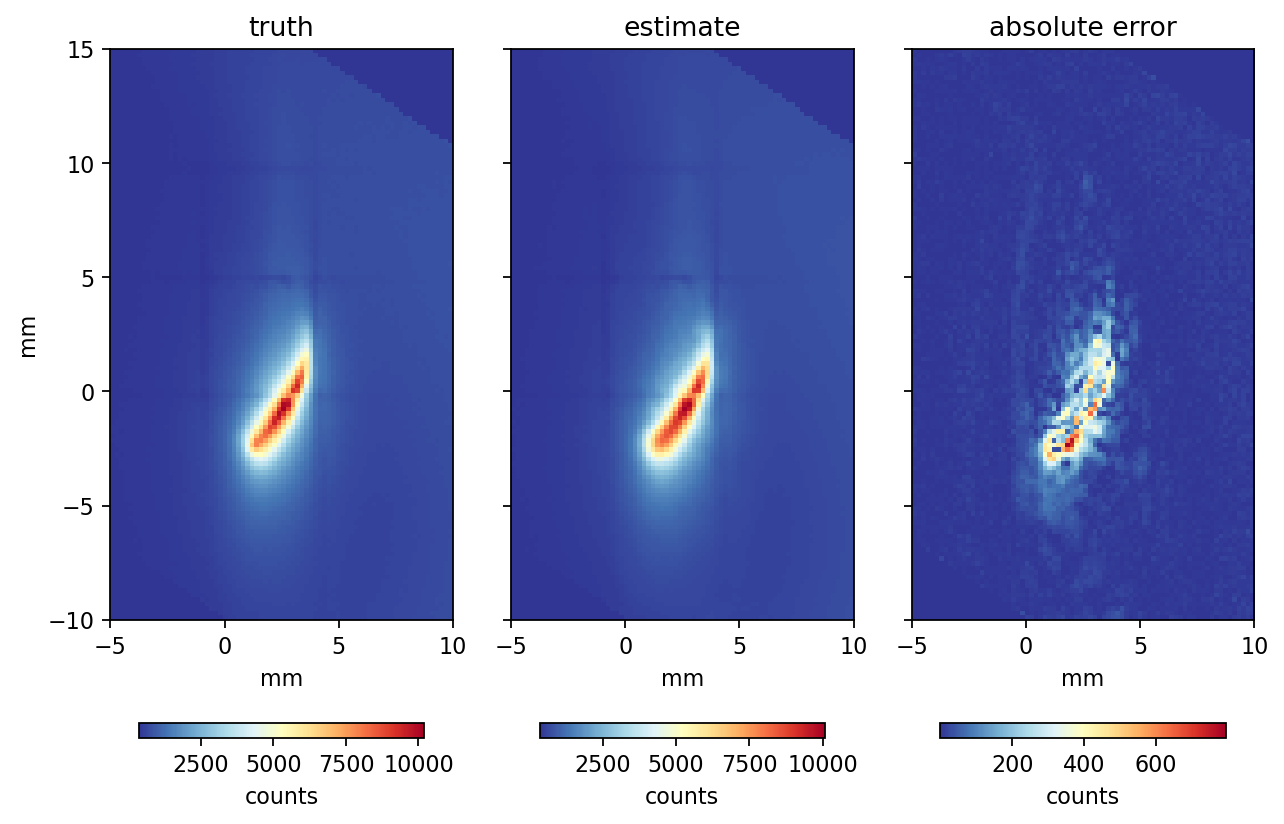

In [35]:
i = 2209

test_i = test_index[i]

guess = (model(x[test_i]).detach().numpy()+gfbim_avg).reshape(nx,ny)
truth = (y[test_i].detach().numpy()+gfbim_avg).reshape(nx,ny)

fig, axes = plt.subplots(1,3,figsize=(8,5),dpi=160,constrained_layout=True,sharex=True,sharey=True)

for ax, lab, im, in zip(axes, ['truth', 'estimate', 'absolute error'],
                       [truth, guess, np.abs(guess-truth)]):
    
    ref = ax.imshow(im.T, extent=[*x_range,*y_range])
    ax.set_title(lab, fontsize=12), ax.set_xlabel('mm')
    clb = fig.colorbar(ref,ax=ax,location='bottom',shrink=.8)
    clb.set_label('counts')
    
axes[0].set_ylabel('mm')

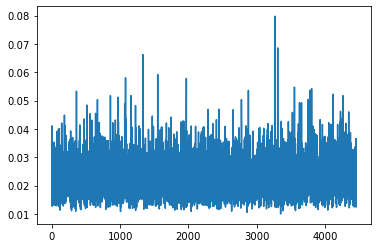

In [37]:
total_pred = model(x[test_index]).detach().numpy() + gfbim_avg
total_true = y[test_index].detach().numpy() + gfbim_avg
rel_error  = (np.abs(total_pred-total_true)/np.abs(total_true)).mean(axis=-1)
plt.plot(rel_error)

In [42]:
x_df.values

array([[0.     , 1.     , 1.     , 0.     ],
       [0.     , 1.     , 1.     , 0.0345 ],
       [0.     , 1.     , 1.     , 0.06895],
       ...,
       [0.     , 0.     , 0.     , 0.06895],
       [0.     , 0.     , 0.     , 0.0345 ],
       [0.     , 0.     , 0.     , 0.     ]])

In [43]:
import scipy as sp
from scipy import stats, interpolate, optimize

n_p = 50

p = np.linspace(0,10,n_p)

p_images = (model(torch.tensor(sp.interpolate.interp1d(np.arange(ngf),x_df.values,axis=0)(p), dtype=torch.float)).detach().numpy() + gfbim_avg).reshape(n_p, nx, ny)

In [44]:
p_images.shape

(50, 76, 126)

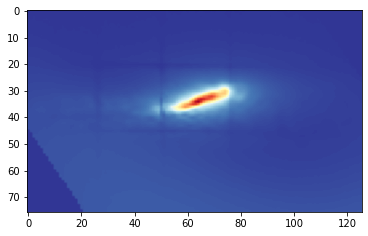

In [45]:
plt.figure()
plt.imshow(p_images[-1])
plt.show()

In [46]:
n_frames = len(p)

AttributeError: module 'matplotlib.pyplot' has no attribute 'clear'

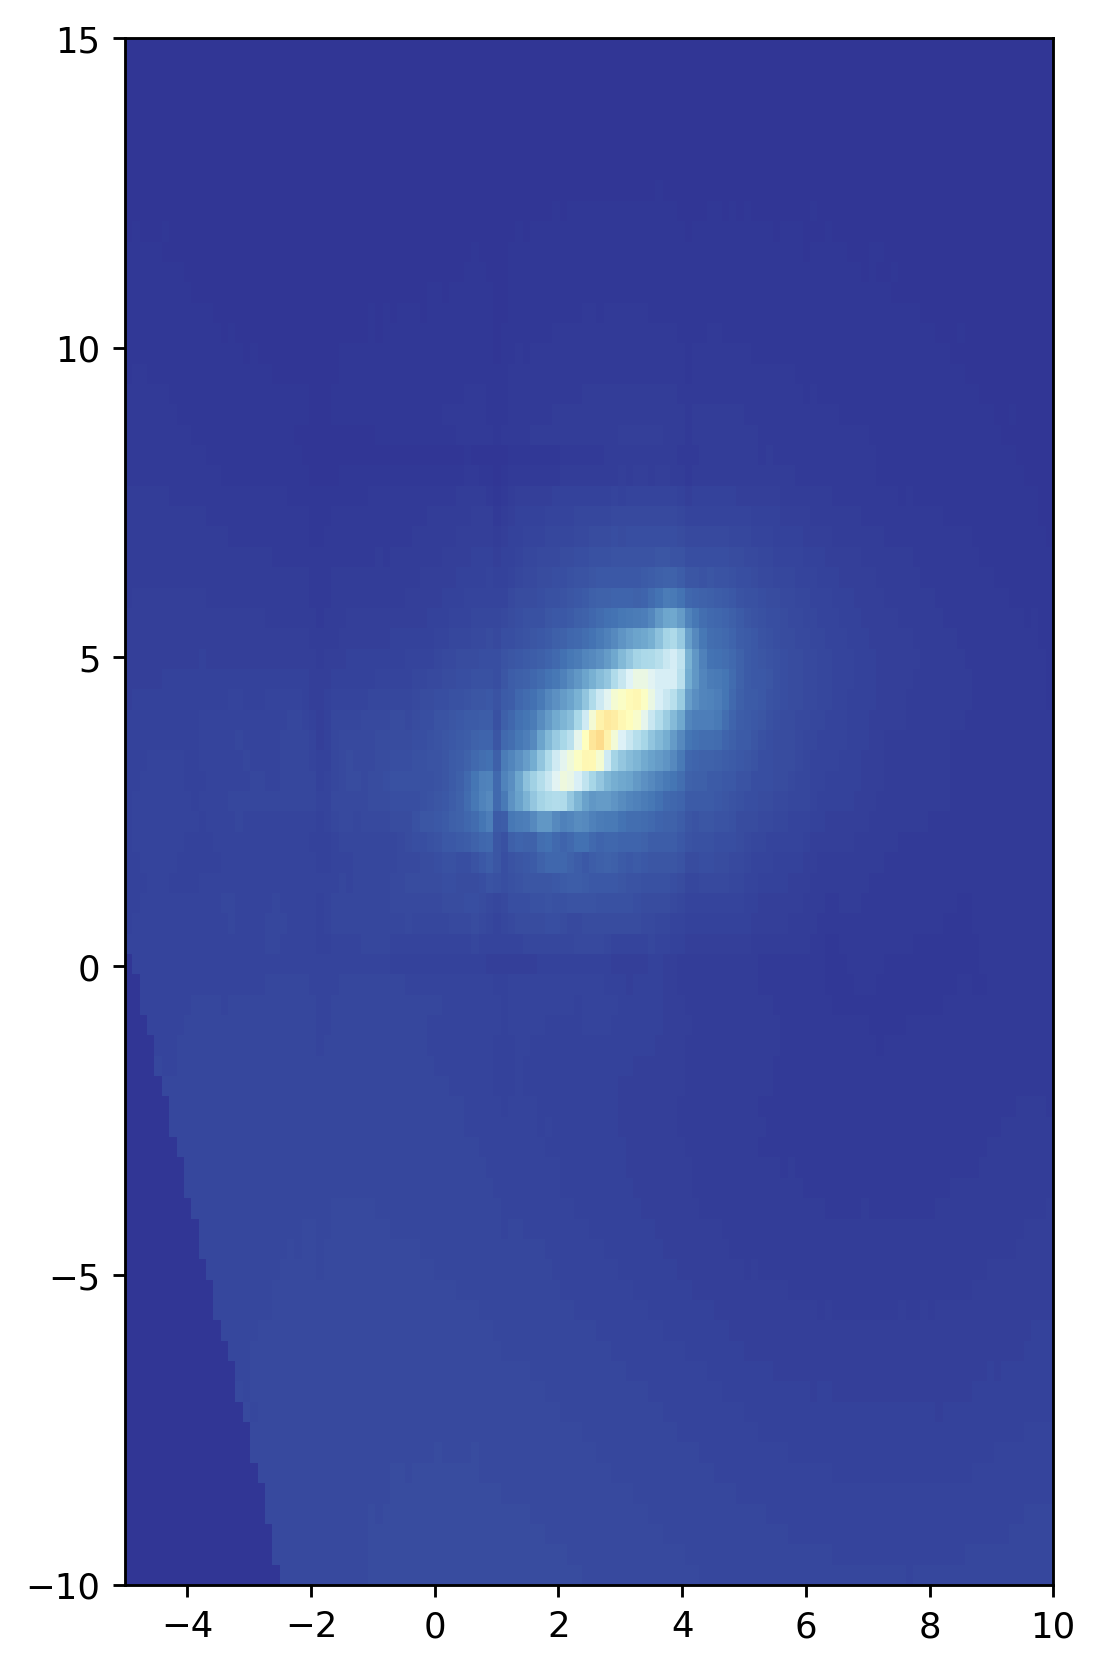

In [47]:
import IPython

import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np


fig, ax = plt.subplots(figsize=(16,8), dpi=256)
l = ax.imshow(p_images[0], extent=[*x_range,*y_range])

def animate(t):
    l.set_data(p_images[t])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=n_frames, interval=5000/len(p))

from IPython.display import HTML
HTML(ani.to_jshtml())
plt.clear()